In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [5]:
# 构建不带分类器的预训练模型
base_model = ResNet50(weights='imagenet', include_top=False)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [6]:
!ls ~/.keras/models

resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'data/medicine/'
TRAIN_DIR = base_dir + 'train/'
VAL_DIR = base_dir + 'test/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
IMG_W,IMG_H =224,224 # 单张图片的大小
BATCH_SIZE = 16
# 2，准备训练集，keras有很多Generator可以直接处理图片的加载，增强等操作，封装的非常好
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( # 单张图片的处理方式，train时一般都会进行图片增强
        rescale=1. / 255, # 图片像素值为0-255，此处都乘以1/255，调整到0-1之间
        shear_range=0.2, # 斜切
        zoom_range=0.2, # 放大缩小范围
        horizontal_flip=True) # 水平翻转

train_generator = train_datagen.flow_from_directory(# 从文件夹中产生数据流
    TRAIN_DIR, # 训练集图片的文件夹
    target_size=(IMG_W, IMG_H), # 调整后每张图片的大小
    batch_size=BATCH_SIZE,
    class_mode='categorical') # 此处是多分类问题，故而mode是categorical


Found 362 images belonging to 3 classes.


In [8]:
# 3，同样的方式准备测试集
val_datagen = ImageDataGenerator(rescale=1. / 255) # 只需要和trainset同样的scale即可，不需增强
val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(IMG_W, IMG_H),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 84 images belonging to 3 classes.


In [9]:
#统计分类数
num_classes = len(train_generator.class_indices)
class_dictionary = train_generator.class_indices
print(num_classes)
print(class_dictionary)

3
{'枸杞子': 0, '白术 ': 1, '茯苓': 2}


In [0]:
from keras import optimizers
# 添加全局平均池化层
x = base_model.output
x = GlobalAveragePooling2D()(x)

# 添加一个全连接层
x = Dense(512, activation='relu')(x)

# 添加一个分类器，假设我们有3个类
predictions = Dense(3, activation='softmax')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)

# 首先，我们只训练顶部的几层（随机初始化的层）
# 锁住所有 InceptionV3 的卷积层
# for layer in base_model.layers:
#     layer.trainable = False

# 编译模型（一定要在锁层以后操作）
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [0]:
# 模型的训练
NUM_EPOCHS = 10
BATCH_SIZE = 16
num_train_images = 362
num_val_images = 84
history_1 = model.fit_generator(train_generator, # 数据流
                        steps_per_epoch=num_train_images // BATCH_SIZE, 
                        epochs=NUM_EPOCHS,
                        shuffle = True, 
                        verbose = 1, 
                        validation_data=val_generator,
                        validation_steps=num_val_images // BATCH_SIZE)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


22/22 [==============================] - 12s 552ms/step - loss: 0.2469 - acc: 0.9643 - val_loss: 0.2140 - val_acc: 0.9265
Epoch 2/10
22/22 [==============================] - 12s 531ms/step - loss: 0.1807 - acc: 0.9813 - val_loss: 0.1931 - val_acc: 0.9706
Epoch 3/10
22/22 [==============================] - 12s 534ms/step - loss: 0.1827 - acc: 0.9744 - val_loss: 0.1512 - val_acc: 0.9559
Epoch 4/10
22/22 [==============================] - 12s 529ms/step - loss: 0.1506 - acc: 0.9829 - val_loss: 0.1515 - val_acc: 0.9706
Epoch 5/10
22/22 [==============================] - 12s 553ms/step - loss: 0.1269 - acc: 0.9886 - val_loss: 0.1375 - val_acc: 0.9750
Epoch 6/10
22/22 [==============================] - 12s 526ms/step - loss: 0.1260 - acc: 0.9825 - val_loss: 0.1171 - val_acc: 0.9853
Epoch 7/10
22/22 [==============================] - 12s 543ms/step - loss: 0.1058 - acc: 0.9886 - val_loss: 0.1263 - val_acc: 0.9559
Epoch 8/10
22/22 [==============================] - 12s 551ms/step - loss: 0.095

In [0]:
# 画图，将训练时的acc和loss都绘制到图上
import matplotlib.pyplot as plt

%matplotlib inline

def plot_training(history):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    #epochs = range(len(train_acc))
    plt.plot(train_acc,label='Training Accuracy')
    plt.plot(val_acc,label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    #epochs = range(len(train_loss))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

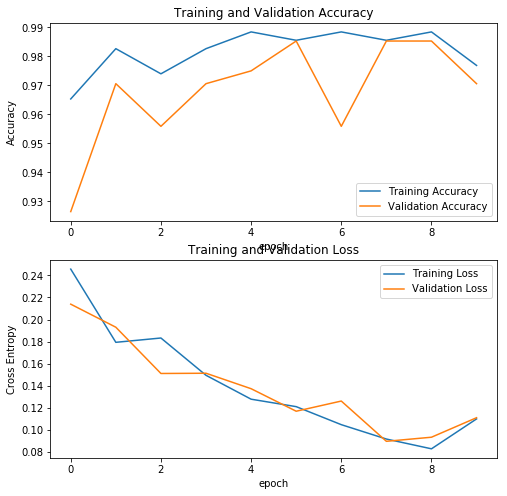

In [0]:
plot_training(history_1)

In [0]:
model.save(base_dir + 'model/' + 'keras_medicine_tl.h5')

In [11]:
#预测
import numpy as np

from keras.models import load_model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
#from keras.applications.inception_v3 import preprocess_input, decode_predictions

#加载模型预测
model = load_model(base_dir + 'model/' + 'keras_medicine_tl.h5')

# 1.读取图片并处理（方法一）
img_path = base_dir + 'tmp/' + 'gq.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x /= 255.
x = np.expand_dims(x, axis=0)
#x = preprocess_input(x) # 使用imagenet_utils的preprocess_input方法处理图片，会导致分类错误,改为 /255
preds = model.predict(x)
print(preds)


print("[INFO] classifying image...")
proba = model.predict(x)[0]
print(proba)
idx = np.argmax(proba)
print(idx)
print(train_generator.class_indices)
print(val_generator.class_indices)

inv_map = {v: k for k, v in train_generator.class_indices.items()}
label = inv_map[idx]
print(label)

[[0.68279696 0.2038744  0.11332864]]
[INFO] classifying image...
[0.68279696 0.2038744  0.11332864]
0
{'枸杞子': 0, '白术 ': 1, '茯苓': 2}
{'枸杞子': 0, '白术': 1, '茯苓': 2}
枸杞子
